In [1]:
#imports
import nest
import yaml
import nest.raster_plot
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram, butter, filtfilt
from analysis_functions import *
from asserting_functions import *
from yaml_io import *
from prepare_nest_parameters import *
from nest_reset_create_connect_simulate import *
from activity_analysis import *


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0
 Built: Jun 14 2024 10:44:24

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [3]:
is_verbose = False
debug_mode = True

#total sim, resolution and recording times
times = read_sim_and_recording_times_yaml(is_verbose)

#read general network parameters
config = read_general_config_yaml(is_verbose)

#prepare all simulation parameters
nest_pms={}
nest_pms = nest_parameters_preparation(times, config, is_verbose, nest_pms)
print("nest_pms",nest_pms)

in read_sim_and_recording_times_yaml: verbose mode is False
in read_general_config_yaml: verbose mode is False
in nest_parameters_preparation: verbose mode is False
in read_neural_parameters: verbose mode is False
in read_neural_parameters: verbose mode is False
nest_pms {'exc_pms': {'multi_compartment': False, 'neuron_kind': 'excitatory', 'equation_params': {'a': 0, 't_ref': 0.0, 'Delta_T': 2.0, 'C_m': 362.5648533496359, 'g_L': 6.666182946322264, 'tau_w': 500.0, 'V_th': -50.0, 'V_peak': -40.0, 'b_awake': 40.0, 'E_L_awake': -58.656837907086036, 'V_reset_awake': -62.12885359171539, 'b_NREM': 200.0, 'E_L_NREM': -63.656837907086036, 'V_reset_NREM': -62.12885359171539}}, 'contextual_poisson': {'awake': {'basic_rate': 3000.0, 'poisson_weight': 0.6, 'spreading_factor': 4, 'start_time': 6000.0, 'stop_time': 6500.0, 'target_pop': 2}}, 'sim_pms': {'stop_ms': 15000.0, 'resolution_ms': 0.1}, 'use_single_compartment_environment': True, 'exc_neu_params': {'receptors': {}, 'equation_params': {'a': 0

In [4]:
NEST_version = nest.__version__
if NEST_version == "3.7.0" and nest_pms["use_single_compartment_environment"]==False:
    print("ASSERTION ERROR: Ca-AdEx multi-compartment neuron not supported by this NEST version", NEST_version)
    assert(False)

In [5]:
num_threads=4
sim_completed, spike_recorders, inh_spike_recorder = nest_reset_create_connect_simulate(nest_pms,num_threads)
print("sim_completed", sim_completed)


Aug 17 19:02:54 SimulationManager::set_status [Info]: 
IN nest_reset_create_connect_simulate: use_single_compartment_environment = True
sim_completed True
    Temporal resolution changed from 0.1 to 0.1 ms.

Aug 17 19:02:54 NodeManager::prepare_nodes [Info]: 
    Preparing 208 nodes for simulation.

Aug 17 19:02:54 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 208
    Simulation time (ms): 15000
    Number of OpenMP threads: 4
    Not using MPI

Aug 17 19:03:00 SimulationManager::run [Info]: 
    Simulation finished.


In [6]:
d_inh = nest.GetStatus(inh_spike_recorder, "events")[0]

In [7]:
#before analysis, preliminary sim look 
preliminary_sim_look(debug_mode,nest_pms, spike_recorders, inh_spike_recorder, nest_pms["recording_pms"])   

pop 0 first recorded event at time 5011.2 from sender 20
pop 0 last recorded event at time 14960.9 from sender 15
pop 0 total_exc_pop_spikes= 915
pop 0 average_exc_pop_firing_rate_Hz= 4.575 Hz
pop 1 first recorded event at time 5026.400000000001 from sender 40
pop 1 last recorded event at time 15000.0 from sender 35
pop 1 total_exc_pop_spikes= 905
pop 1 average_exc_pop_firing_rate_Hz= 4.525 Hz
pop 2 first recorded event at time 5024.5 from sender 52
pop 2 last recorded event at time 14890.7 from sender 43
pop 2 total_exc_pop_spikes= 1034
pop 2 average_exc_pop_firing_rate_Hz= 5.170000000000001 Hz
pop 3 first recorded event at time 5146.1 from sender 72
pop 3 last recorded event at time 14954.300000000001 from sender 67
pop 3 total_exc_pop_spikes= 902
pop 3 average_exc_pop_firing_rate_Hz= 4.510000000000001 Hz
INHIBITORIES 3 first recorded event at time 5025.2 from sender 84
INHIBITORIES 3 last recorded event at time 14998.5 from sender 99
INHIBITORIES 3 total_inh_pop_spikes= 5840
INHIBIT

In [8]:
verbose=False

#here we prepare all the parameters for the following analysis and print
crop_pms, plot_pms, sampling_pms, analysis_pms =\
    prepare_crop_plot_sampling_activityAnalysis_parameters(nest_pms, verbose)

# Assuming spike_recorders is a list of spike recorder IDs previously created in your NEST simulation
cropped_events = crop_events_from_spike_recorders(crop_pms, spike_recorders)
cropped_inh_events = crop_inh_events(crop_pms, inh_spike_recorder)

in read_crop_and_plot_yaml: verbose mode is False
---RECORDING INTERVAL---
start recording at time 5000.0 ms
stop recording at time 15000.0 ms
recording_duration 10000.0 ms
---CROPPING INTERVAL
crop start at time 5000.0 ms
crop stop at time 15000.0 ms
crop duration 10000.0 ms
---HIGH FREQ analysis AND (spikes) 
spectogram window 2000.0 ms
lower_detectable_frequency 0.5 Hz
spikes sampling window 0.2 ms
analysis sampling freq 5000.0 Hz
max nyquist frequency 2500.0 Hz
----LOW FREQ analysis (ECG, LFP like)
(low freq) spectrogram window 2000.0 ms
lower_detectable_frequency 0.5 Hz
low freq sampling window 12.5 ms
low freq sampling freq 80.0 Hz
(low_freq) max nyquist frequency 40.0 Hz
(low freq) spectrogram window 2000.0 ms


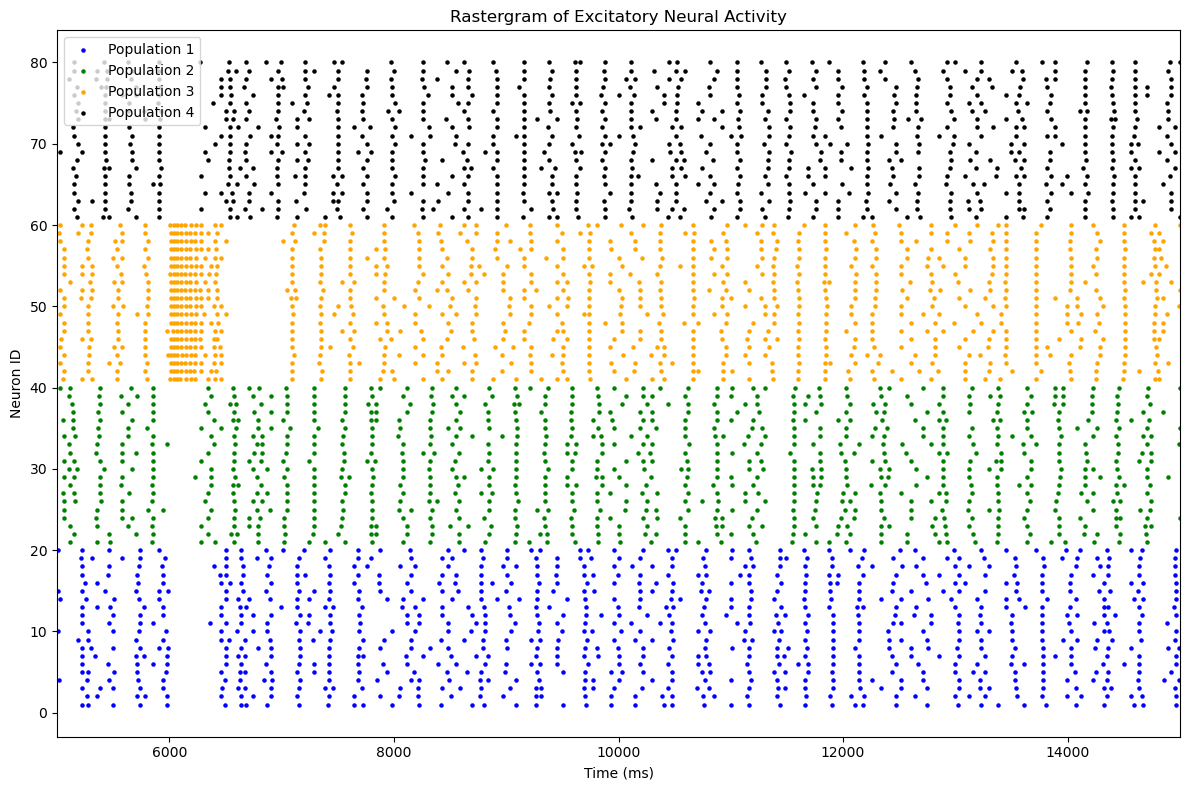

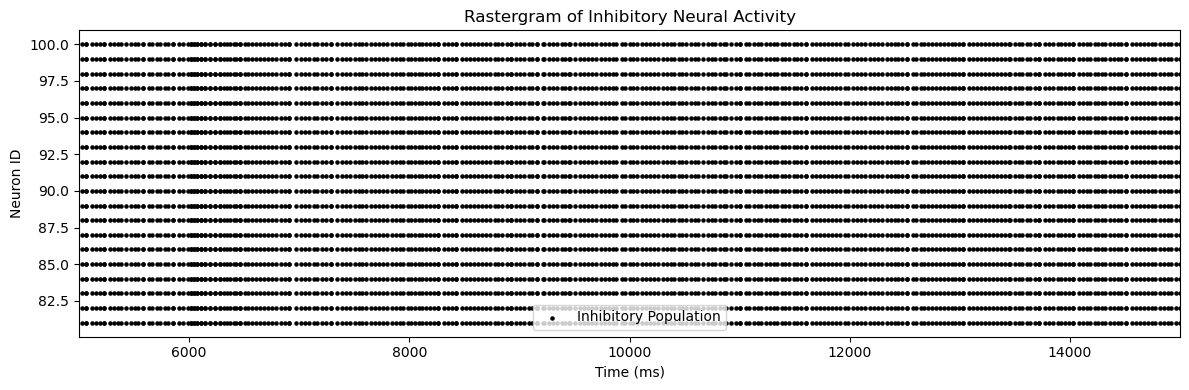

In [15]:
#produce the rastegrams
#PLEASE: select if the exc, inh or both are needed from yaml files
produce_rastegrams(nest_pms, plot_pms, crop_pms, cropped_events, cropped_inh_events, verbose)

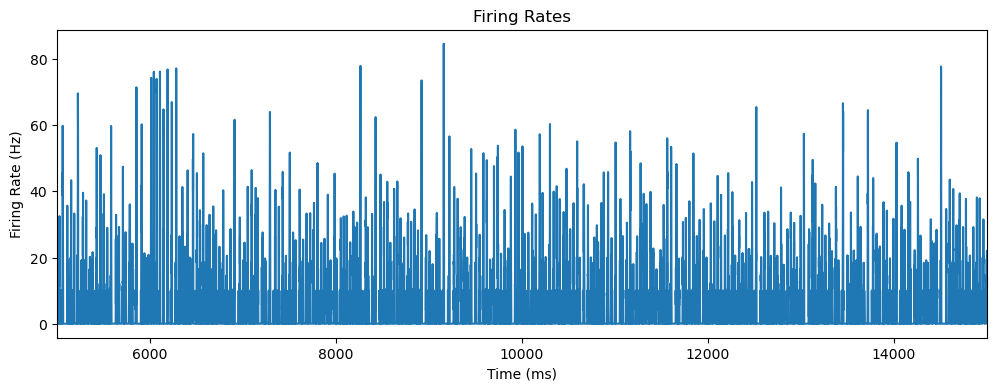

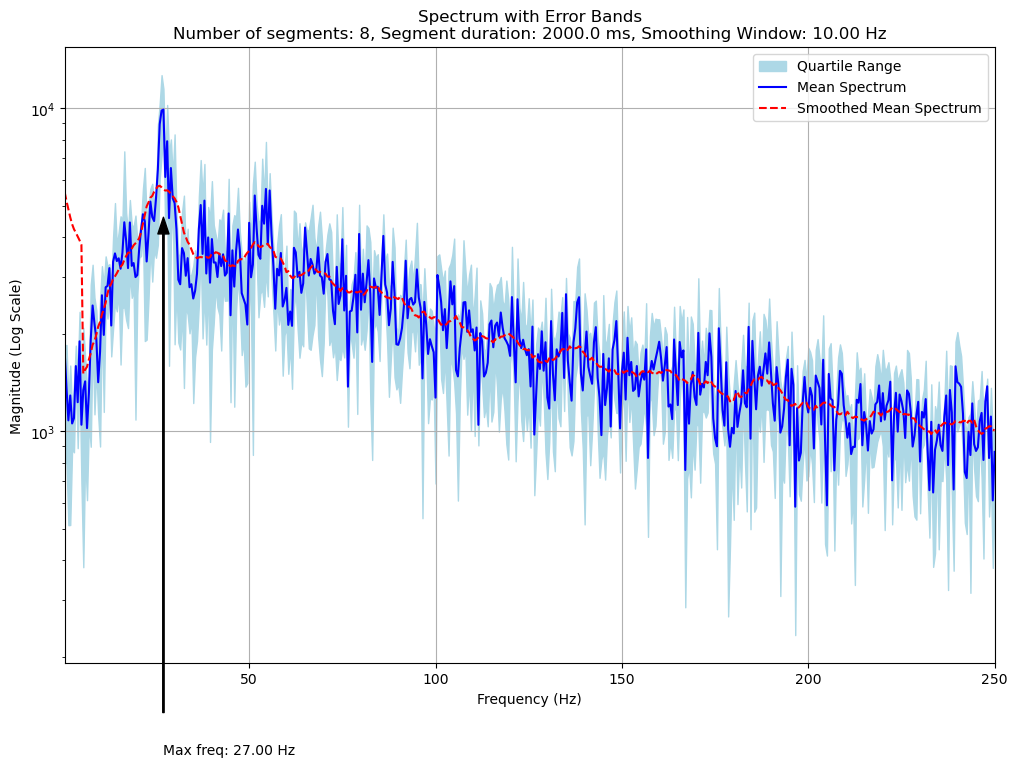

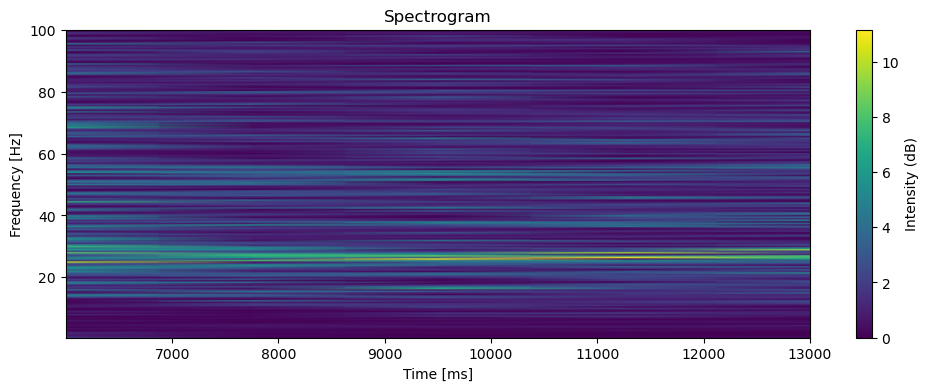

In [18]:
#produce activity rates, spectrum and spectrogram from spikes
#includes filter to transform spike-times into spike-like waveforms
high_frequency_analysis_from_spikes(\
    nest_pms, plot_pms, crop_pms, analysis_pms,\
    cropped_events, verbose)

In [ ]:
def produce_tissue_response_activity_spectrum_spetrogram(\
    plot_pms, analysis_pms, time_points, smoothed_spikes_firing_rate
    
#creating a kernel to smooth the spike-like waveforms 
#with tissue- and synaptic-like times for 
#ECG/LFP/ECoG like analysis
#gaussiam kernel: typical values: duration_ms=100ms, std_dev_ms=12.0
tissue_response_kernel = prepare_tissue_response_kernel(analysis_pms, plot_pms, crop_pms, verbose)
#evaluating activity from tissue response
tissue_response_rate = smooth_signal(smoothed_spikes_firing_rate, tissue_response_kernel)
if verbose: 
    print("len of tissue signal", len(tissue_response_rate))
    print("type of tissue signal", type(tissue_response_rate))
if plot_pms['tissue_response_rate']==True:
    firing_rates_plot(time_points, tissue_response_rate, crop_pms) 

#dividing the data in segments for reliable spectral analysis
max_plot_freq_Hz=plot_pms['tissue_response_spectrum']['max_plot_freq_Hz']
smoothing_length=plot_pms['tissue_response_spectrum']['smoothing_lenght'] #frequency samples
if plot_pms['tissue_response_spectrum']['plot']==True:
    compute_spectrum_with_error_bands(tissue_response_rate, analysis_pms, max_plot_freq_Hz, smoothing_length)
    max_plot_freq_Hz=plot_pms['tissue_response_spectrogram']['max_plot_freq_Hz']

#Spectrogram plot
if plot_pms['tissue_response_spectrogram']['plot']==True:
    plot_spectrogram(time_points[0],\
                 tissue_response_rate,\
                 analysis_pms, max_plot_freq_Hz)

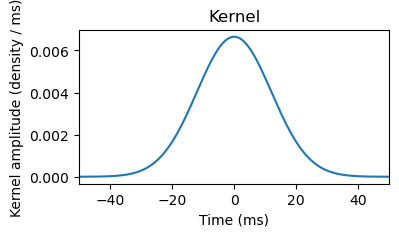

In [12]:
#creating a kernel to smooth the spike-like waveforms 
#with tissue- and synaptic-like times for 
#ECG/LFP/ECoG like analysis
#gaussiam kernel: typical values: duration_ms=100ms, std_dev_ms=12.0
tissue_response_kernel = prepare_tissue_response_kernel(analysis_pms, plot_pms, crop_pms, verbose)

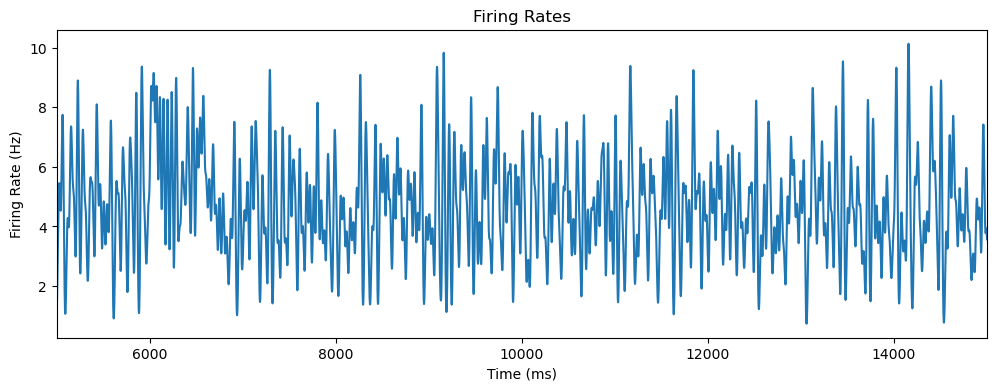

In [13]:
#evaluating activity from tissue response
tissue_response_rate = smooth_signal(smoothed_spikes_firing_rate, tissue_response_kernel)
if verbose: 
    print("len of tissue signal", len(tissue_response_rate))
    print("type of tissue signal", type(tissue_response_rate))
if plot_pms['tissue_response_rate']==True:
    firing_rates_plot(time_points, tissue_response_rate, crop_pms) 

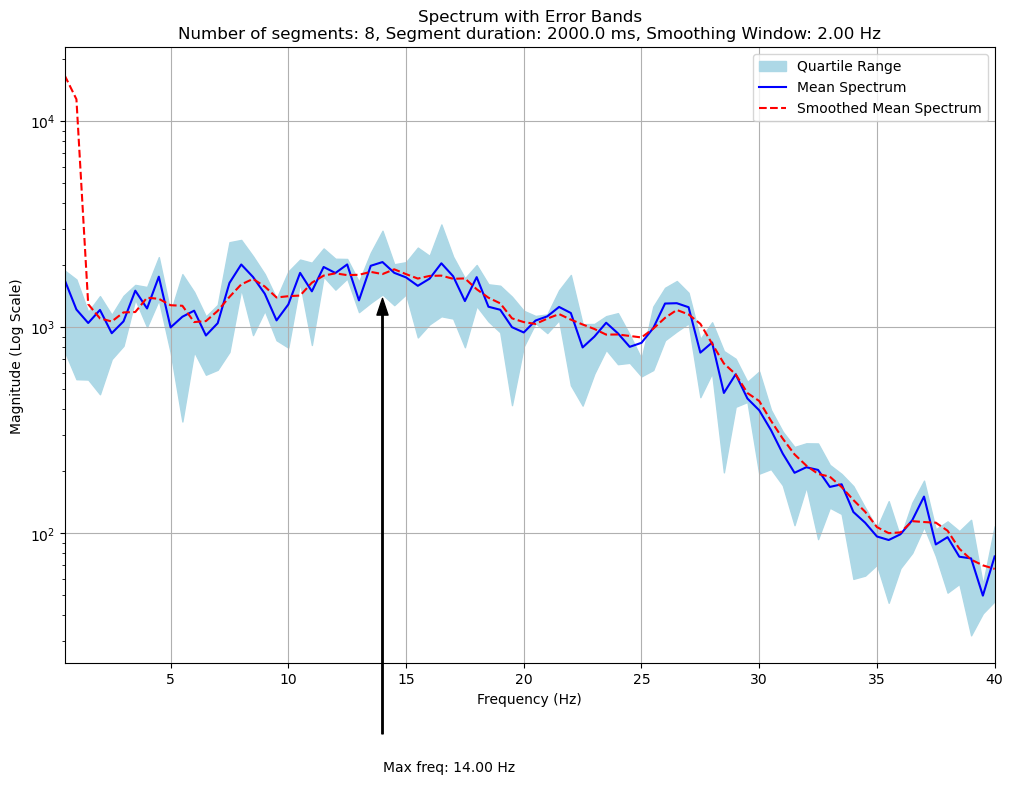

In [14]:
#dividing the data in segments for reliable spectral analysis
max_plot_freq_Hz=plot_pms['tissue_response_spectrum']['max_plot_freq_Hz']
smoothing_length=plot_pms['tissue_response_spectrum']['smoothing_lenght'] #frequency samples
if plot_pms['tissue_response_spectrum']['plot']==True:
    compute_spectrum_with_error_bands(tissue_response_rate, analysis_pms, max_plot_freq_Hz, smoothing_length)

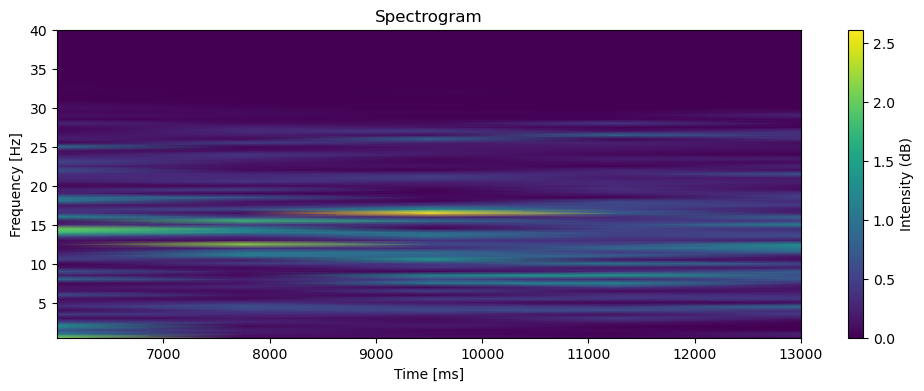

In [15]:
max_plot_freq_Hz=plot_pms['tissue_response_spectrogram']['max_plot_freq_Hz']
#Spectrogram plot
if plot_pms['tissue_response_spectrogram']['plot']==True:
    plot_spectrogram(time_points[0],\
                 tissue_response_rate,\
                 analysis_pms, max_plot_freq_Hz)

In [16]:
plt.show()